In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# loaded

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
labels = ['NORMAL','PNEUMONIA']

In [ ]:
import numpy as np

# Load the saved NumPy arrays
X_full = np.load('/content/drive/MyDrive/Capstone/data/X_full.npy')
y_full = np.load('/content/drive/MyDrive/Capstone/data/y_full.npy')

print('Arrays loaded successfully.')


Arrays loaded successfully.


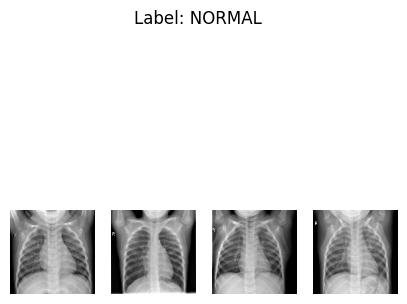

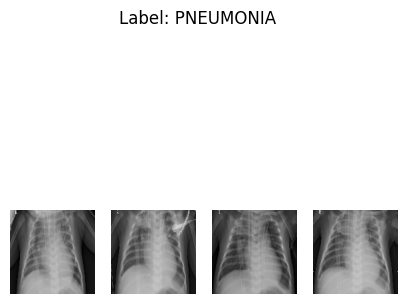

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Get unique labels
unique_labels = np.unique(y_full)

# Display 5 sample images from each label
num_samples = 4

for label in unique_labels:
    # Get indices of images with the current label
    indices = np.where(y_full == label)[0][:num_samples]

    # Select the corresponding images
    images = X_full[indices]

    # Plot the images
    plt.figure(figsize=(5, 5))
    for i, image in enumerate(images):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle('Label: ' + str(label))
    plt.show()


In [ ]:
X_full = []
y_full = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Capstone/data',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 4273/4273 [02:00<00:00, 35.45it/s] 


In [ ]:

X_full = np.array(X_full)
y_full = np.array(y_full)


In [ ]:
y_full_new = []
for i in y_full:
    y_full_new.append(labels.index(i))
y_full = y_full_new
y_full = tf.keras.utils.to_categorical(y_full)

# split and encode

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.2,random_state=101)

In [ ]:
len(X_test)

1172

In [ ]:
del X_full,y_full

In [ ]:
del y_full_new

# train EfficientNetB2, MobileNetV2, ResNet50V2, DenseNet121 and plot graphs

In [ ]:
from keras.applications import EfficientNetB2, MobileNetV2, DenseNet121, ResNet50V2
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

def train_models(X_train, X_test, y_train, y_test):
    # Define image size
    image_size = 128
    img_size = (image_size, image_size)

    # Create model architecture
    models = [EfficientNetB2, MobileNetV2, ResNet50V2, DenseNet121]
    #models = [EfficientNetB2]
    history=[]
    mods=[]
    for model in models:
        # Load pre-trained model
        base_model = model(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
        reduce_lr = ReduceLROnPlateau(monitor = 'accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',verbose=1)
        # Freeze pre-trained layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers
        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dropout(0.8))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(2, activation='softmax'))

        # Compile model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model
        hist=model.fit(X_train,
                 y_train,
                 validation_split=0.1,
                 verbose=1,
                 batch_size=64, epochs=10,
                 callbacks=reduce_lr)
        history.append(hist)
        mods.append(model)
    return history, mods

In [ ]:
history, mods=train_models(X_train, X_test, y_train, y_test)

Epoch 1/10
66/66 [==============================] - 21s 147ms/step - loss: 0.4717 - accuracy: 0.8641 - val_loss: 0.1442 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 5s 78ms/step - loss: 0.1984 - accuracy: 0.9215 - val_loss: 0.1833 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 5s 75ms/step - loss: 0.1763 - accuracy: 0.9340 - val_loss: 0.1012 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 5s 77ms/step - loss: 0.1569 - accuracy: 0.9362 - val_loss: 0.1128 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 5s 76ms/step - loss: 0.1727 - accuracy: 0.9298 - val_loss: 0.1175 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 5s 75ms/step - loss: 0.1437 - accuracy: 0.9440 - val_loss: 0.1104 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 5s 75ms/step - loss: 0

In [ ]:
import matplotlib.pyplot as plt

model_names =['EfficientNetB2', 'MobileNetV2', 'ResNet50V2', 'DenseNet121']


def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], model_name, ha='right', va='bottom')
    #plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], model_name, ha='right', va='bottom')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.text(len(history.history['loss'])-1, history.history['loss'][-1], model_name, ha='right', va='bottom')
    #plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], model_name, ha='right', va='bottom')
    plt.show()


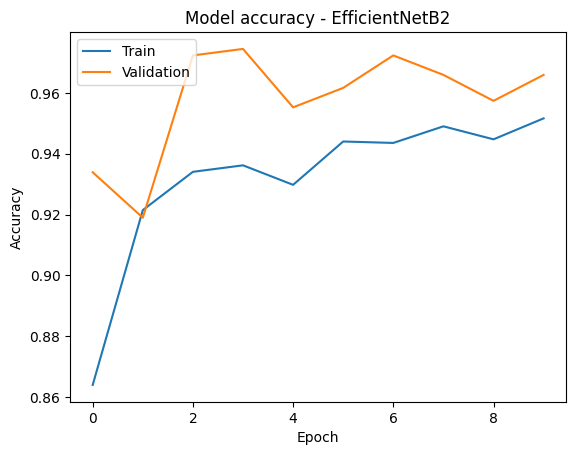

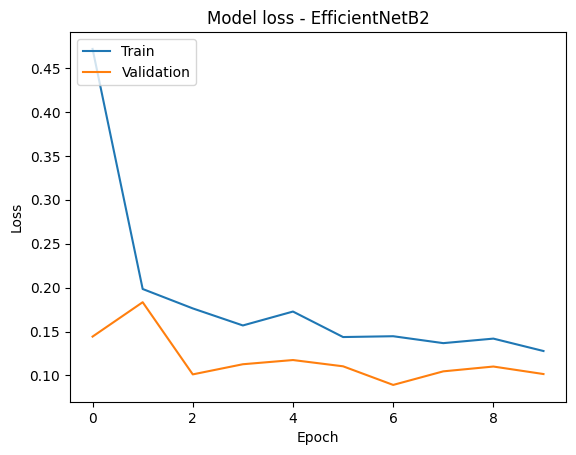

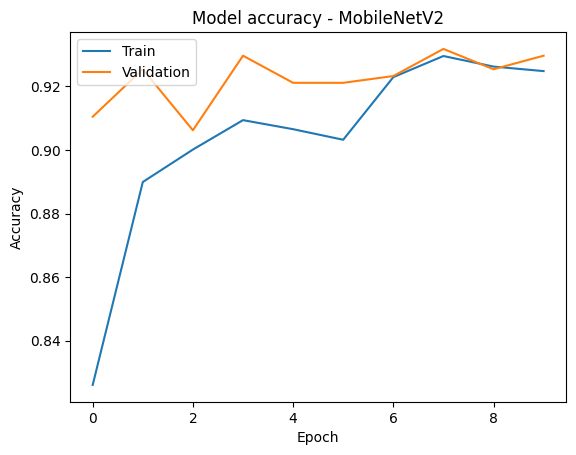

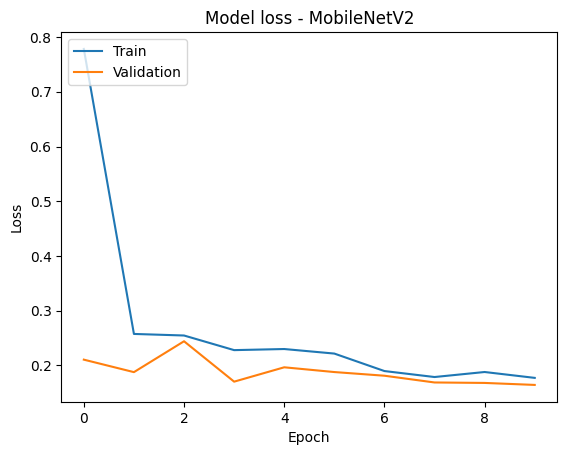

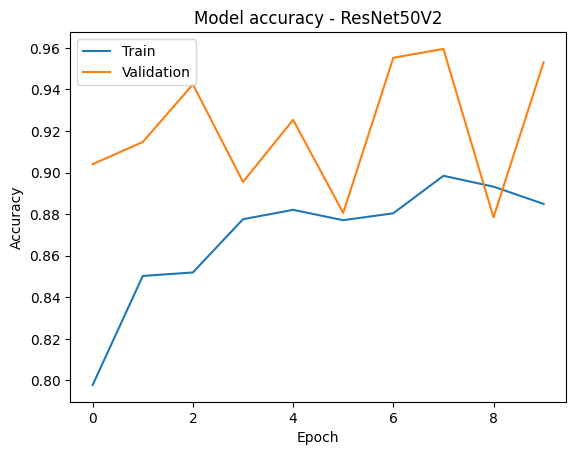

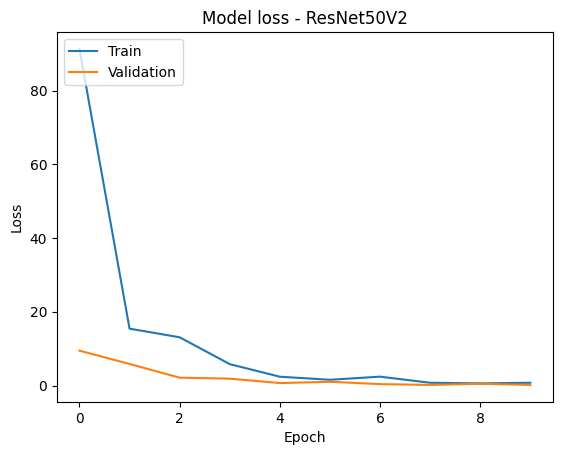

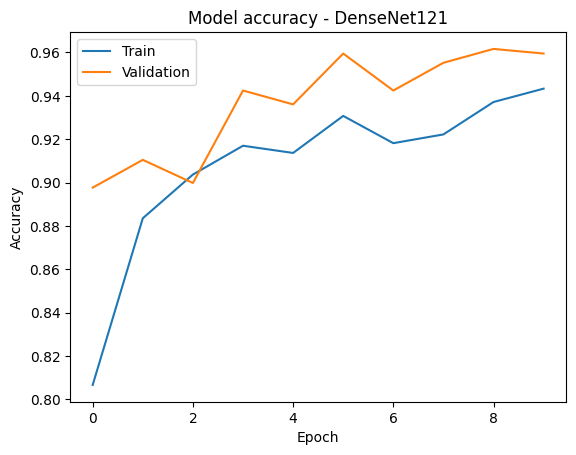

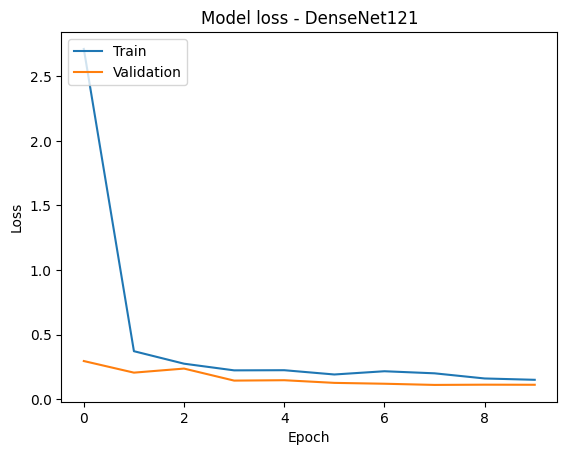

In [ ]:
for i, h in enumerate(history):
    plot_history(h, model_names[i])


37/37 [==============================] - 1s 36ms/step
EfficientNetB2
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       311
           1       0.97      0.97      0.97       861

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.96      0.95      0.95      1172



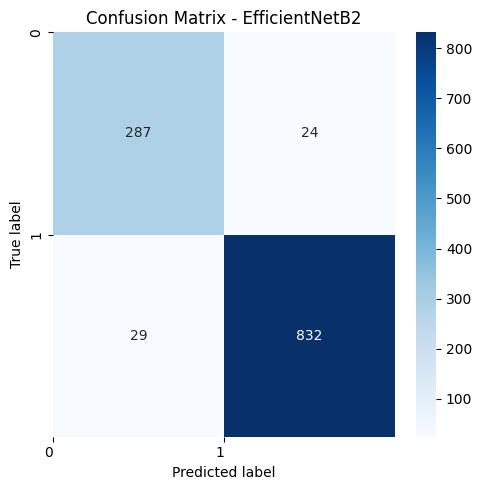

37/37 [==============================] - 1s 18ms/step
MobileNetV2
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       311
           1       0.96      0.94      0.95       861

    accuracy                           0.92      1172
   macro avg       0.90      0.91      0.90      1172
weighted avg       0.93      0.92      0.92      1172



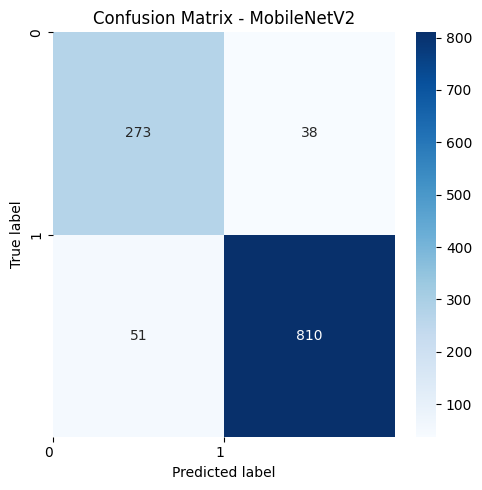

37/37 [==============================] - 1s 31ms/step
ResNet50V2
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       311
           1       0.92      0.99      0.95       861

    accuracy                           0.93      1172
   macro avg       0.94      0.87      0.90      1172
weighted avg       0.93      0.93      0.92      1172



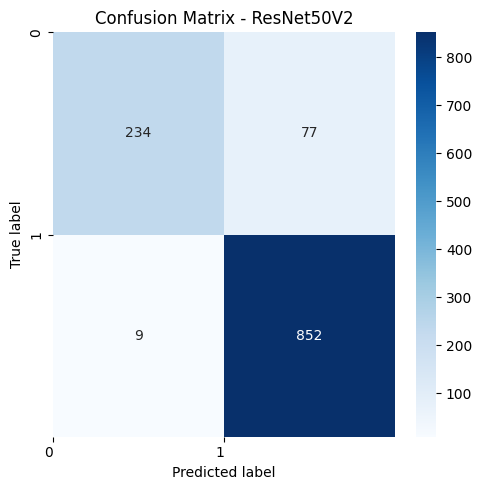

37/37 [==============================] - 1s 31ms/step
DenseNet121
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       311
           1       0.95      0.98      0.97       861

    accuracy                           0.95      1172
   macro avg       0.95      0.92      0.94      1172
weighted avg       0.95      0.95      0.95      1172



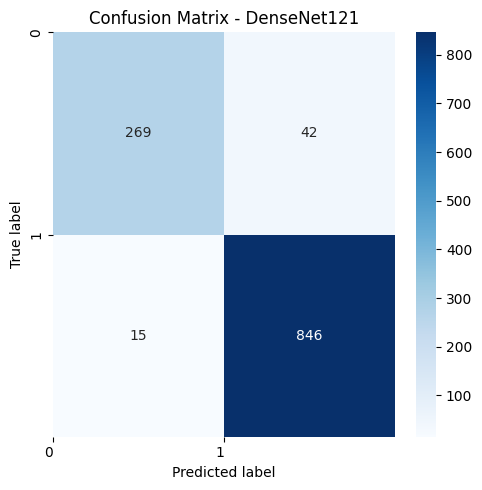

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Iterate over models
for i, model in enumerate(mods):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_test_new = np.argmax(y_test, axis=1)

    # Print classification report
    print(model_names[i])
    print(classification_report(y_test_new, pred))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_new, pred)

    # Create a figure and axis with larger size
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot the confusion matrix using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Set labels, title, and ticks
    classes = np.unique(y_test_new)
    num_classes = len(classes)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'Confusion Matrix - {model_names[i]}')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Adjust the layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
for m in mods:
    pred = m.predict(X_test)
    pred = np.argmax(pred,axis=1)
    y_test_new = np.argmax(y_test,axis=1)
    print(classification_report(y_test_new,pred))
    print(confusion_matrix(y_test_new,pred))

37/37 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       311
           1       0.97      0.97      0.97       861

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.96      0.95      0.95      1172

[[287  24]
 [ 29 832]]
37/37 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       311
           1       0.96      0.94      0.95       861

    accuracy                           0.92      1172
   macro avg       0.90      0.91      0.90      1172
weighted avg       0.93      0.92      0.92      1172

[[273  38]
 [ 51 810]]
37/37 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       311
           1       0.92      

In [ ]:
for i, m in enumerate(mods):
  results2 = m.evaluate(X_test,y_test)
  results = m.evaluate(X_train,y_train)
  print(model_names[i])
  print("test: "+str(results2))
  print("train: "+str(results))

147/147 [==============================] - 5s 35ms/step - loss: 0.0808 - accuracy: 0.9714
EfficientNetB2
test: [0.12326842546463013, 0.9547781348228455]
train: [0.08080367743968964, 0.9713919758796692]
147/147 [==============================] - 3s 17ms/step - loss: 0.1369 - accuracy: 0.9449
MobileNetV2
test: [0.18134543299674988, 0.9240614175796509]
train: [0.13691723346710205, 0.9449188709259033]
147/147 [==============================] - 5s 36ms/step - loss: 0.2657 - accuracy: 0.9315
ResNet50V2
test: [0.2352656126022339, 0.92662113904953]
train: [0.26567956805229187, 0.9314688444137573]
147/147 [==============================] - 5s 36ms/step - loss: 0.1028 - accuracy: 0.9611
DenseNet121
test: [0.13352429866790771, 0.9513651728630066]
train: [0.10275046527385712, 0.9611443281173706]


37/37 [==============================] - 1s 36ms/step - loss: 0.1335 - accuracy: 0.9514


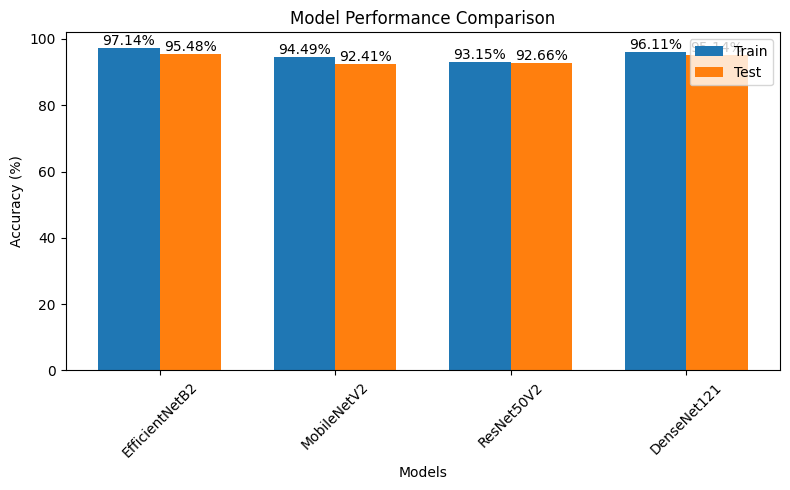

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lists to store the evaluation results
train_results = []
test_results = []

# Iterate over the models
for m in mods:
    results_train = m.evaluate(X_train, y_train)
    results_test = m.evaluate(X_test, y_test)
    train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
    test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list
    train_results.append(train_accuracy)
    test_results.append(test_accuracy)

# List of model names


# Calculate the positions for the bars
bar_width = 0.35
x_train = np.arange(len(model_names))
x_test = x_train + bar_width

# Plotting the bar chart
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
train_bars = plt.bar(x_train, train_results, width=bar_width, label='Train')
test_bars = plt.bar(x_test, test_results, width=bar_width, label='Test')

plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.legend()

# Add annotations with values on top of the bars
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

for bar in test_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.xticks(x_train + bar_width / 2, model_names, rotation=45)
plt.tight_layout()
plt.show()


37/37 [==============================] - 1s 34ms/step


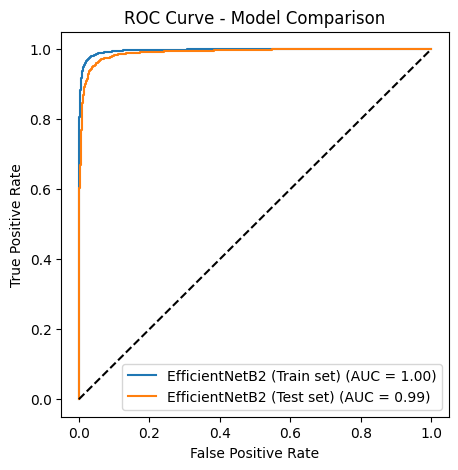

37/37 [==============================] - 1s 17ms/step


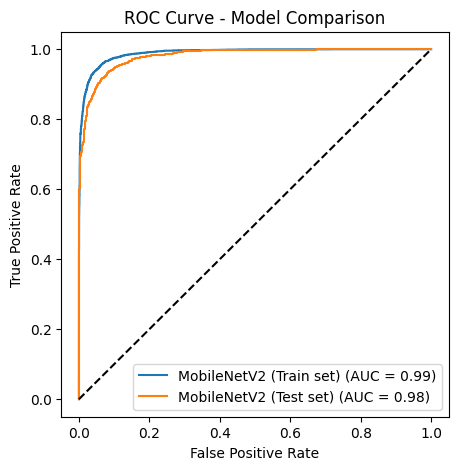

37/37 [==============================] - 1s 34ms/step


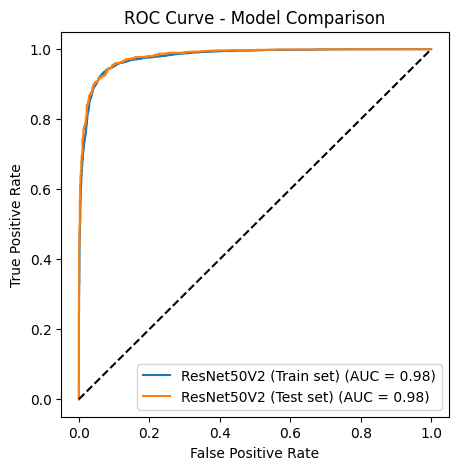

37/37 [==============================] - 1s 31ms/step


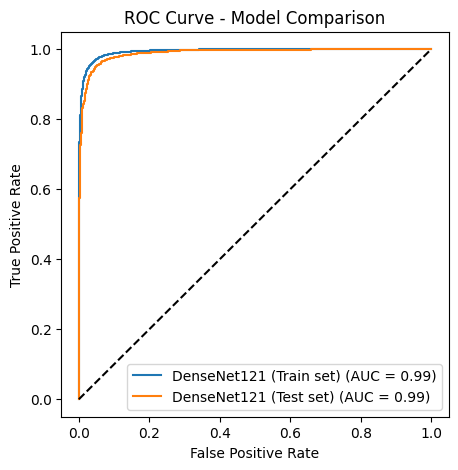

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Iterate over the models
for i, m in enumerate(mods):
    # Evaluate the model
    results_train = m.evaluate(X_train, y_train)
    results_test = m.evaluate(X_test, y_test)
    train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
    test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list

    # Calculate the predicted probabilities for each class
    y_pred_train = m.predict(X_train)
    y_pred_test = m.predict(X_test)

    # Calculate the micro-averaged false positive rate (FPR), true positive rate (TPR), and area under the curve (AUC)
    fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
    fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr_train, tpr_train, label=f'{model_names[i]} (Train set) (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{model_names[i]} (Test set) (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Model Comparison')
    plt.legend(loc='lower right')
    plt.show()


# ENSEMBLE

In [ ]:
from tensorflow.keras.applications import EfficientNetB2, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
efficientnet = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [ ]:
for layer in efficientnet.layers:
    layer.trainable = False

for layer in resnet.layers:
    layer.trainable = False

for layer in mobilenet.layers:
    layer.trainable = False


In [ ]:
efficientnet_feature = GlobalAveragePooling2D()(efficientnet.output)
efficientnet_feature_model = Model(inputs=efficientnet.input, outputs=efficientnet_feature)

resnet_feature = GlobalAveragePooling2D()(resnet.output)
resnet_feature_model = Model(inputs=resnet.input, outputs=resnet_feature)

mobilenet_feature = GlobalAveragePooling2D()(mobilenet.output)
mobilenet_feature_model = Model(inputs=mobilenet.input, outputs=mobilenet_feature)


In [ ]:
concatenated_features = Concatenate()([efficientnet_feature_model.output, resnet_feature_model.output, mobilenet_feature_model.output])


In [ ]:
dense_layer = Dense(256, activation='relu')(concatenated_features)
ensemble_output = Dense(2, activation='softmax')(dense_layer)  # Replace 'num_classes' with your number of classes
ensemble_model = Model(inputs=[efficientnet_feature_model.input, resnet_feature_model.input, mobilenet_feature_model.input], outputs=ensemble_output)


In [ ]:
ensemble_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


In [ ]:
history = ensemble_model.fit([X_train, X_train, X_train], y_train, batch_size=32, epochs=10, validation_data=([X_test, X_test, X_test], y_test))


Epoch 1/10
147/147 [==============================] - 38s 155ms/step - loss: 0.3614 - accuracy: 0.9033 - val_loss: 0.1120 - val_accuracy: 0.9590
Epoch 2/10
147/147 [==============================] - 18s 125ms/step - loss: 0.1166 - accuracy: 0.9562 - val_loss: 0.1410 - val_accuracy: 0.9369
Epoch 3/10
147/147 [==============================] - 16s 111ms/step - loss: 0.1165 - accuracy: 0.9584 - val_loss: 0.0911 - val_accuracy: 0.9676
Epoch 4/10
147/147 [==============================] - 16s 110ms/step - loss: 0.0998 - accuracy: 0.9631 - val_loss: 0.0956 - val_accuracy: 0.9608
Epoch 5/10
147/147 [==============================] - 16s 111ms/step - loss: 0.0754 - accuracy: 0.9722 - val_loss: 0.0875 - val_accuracy: 0.9693
Epoch 6/10
147/147 [==============================] - 16s 111ms/step - loss: 0.0645 - accuracy: 0.9767 - val_loss: 0.1001 - val_accuracy: 0.9667
Epoch 7/10
147/147 [==============================] - 18s 125ms/step - loss: 0.0649 - accuracy: 0.9752 - val_loss: 0.0921 - val_ac

In [ ]:
y_pred = ensemble_model.predict([X_train, X_train, X_train])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_train, axis=1)
accuracy = np.mean(y_pred_classes == y_true_classes) * 100
print('Accuracy: %.2f%%' % accuracy)


147/147 [==============================] - 12s 82ms/step
Accuracy: 99.42%


In [ ]:
y_pred = ensemble_model.predict([X_test, X_test, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_classes == y_true_classes) * 100
print('Accuracy: %.2f%%' % accuracy)


37/37 [==============================] - 3s 80ms/step
Accuracy: 96.67%


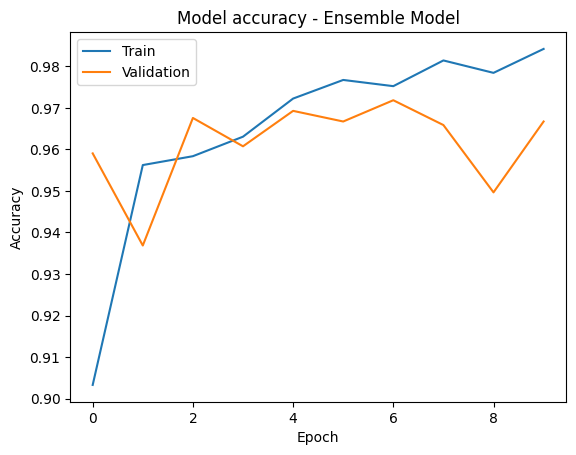

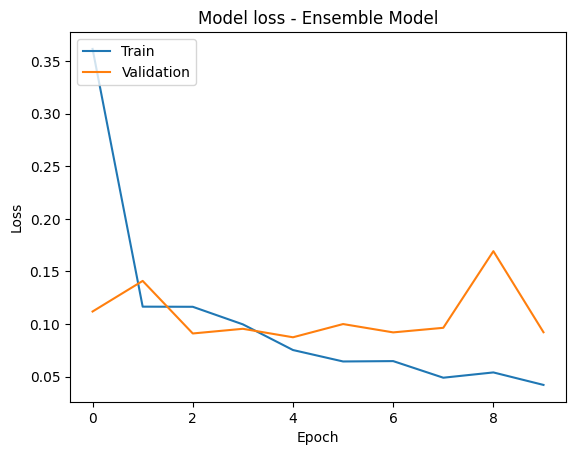

In [ ]:
plot_history(history,"Ensemble Model")

37/37 [==============================] - 3s 84ms/step
Ensemble Model
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       311
           1       0.98      0.97      0.98       861

    accuracy                           0.97      1172
   macro avg       0.95      0.96      0.96      1172
weighted avg       0.97      0.97      0.97      1172



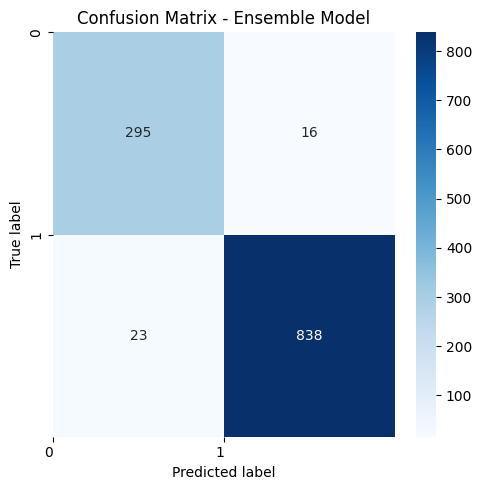

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes for the ensemble model
y_pred_ensemble = ensemble_model.predict([X_test, X_test, X_test])
y_pred_ensemble_classes = np.argmax(y_pred_ensemble, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report for the ensemble model
print("Ensemble Model")
print(classification_report(y_test_classes, y_pred_ensemble_classes))

# Calculate confusion matrix for the ensemble model
cm_ensemble = confusion_matrix(y_test_classes, y_pred_ensemble_classes)

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the confusion matrix for the ensemble model using seaborn
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels, title, and ticks for the confusion matrix
classes = np.unique(y_test_classes)
num_classes = len(classes)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix - Ensemble Model')
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the confusion matrix plot
plt.show()


37/37 [==============================] - 3s 86ms/step


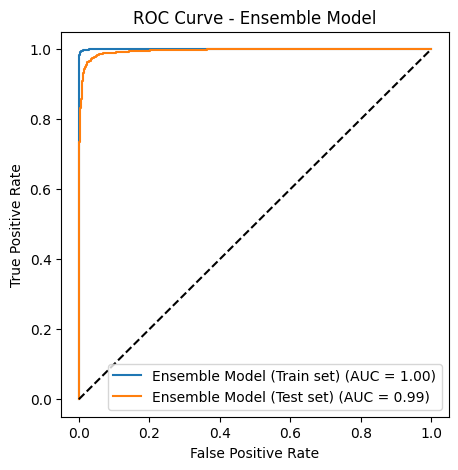

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the predicted probabilities for each class using the ensemble model
y_pred_train = ensemble_model.predict([X_train, X_train, X_train])
y_pred_test = ensemble_model.predict([X_test, X_test, X_test])

# Calculate the micro-averaged false positive rate (FPR), true positive rate (TPR), and area under the curve (AUC)
fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the micro-averaged ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr_train, tpr_train, label=f'Ensemble Model (Train set) (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Ensemble Model (Test set) (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend(loc='lower right')
plt.show()


#Model Summary

In [ ]:
ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 128, 128, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 128, 128, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 128, 128, 3)          0         ['normalization_1[0][0]'

In [ ]:
from keras.utils import plot_model

# Assuming your ensemble model is named ensemble_model
#plot_model(ensemble_model, to_file='ensemble_model_summary.png', show_shapes=True, show_layer_names=True)

#Predict Pneumonia

In [ ]:
#Save the model
#ensemble_model.save('/content/drive/MyDrive/Capstone/ensemble_model.h5')

In [ ]:
from keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/MyDrive/Capstone/ensemble_model.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np


def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def predict_image_class(image_path):
    processed_image = preprocess_image(image_path)
    prediction = loaded_model.predict([processed_image, processed_image, processed_image])
    predicted_class = np.argmax(prediction)
    class_labels = ['NORMAL', 'PNEUMONIA']  # Make sure this matches the order of your classes
    predicted_label = class_labels[predicted_class]
    return predicted_label, prediction

# Example usage
image_path_to_predict = '/content/drive/MyDrive/Capstone/data/PNEUMONIA/person1004_virus_1686.jpeg'
predicted_label, prediction = predict_image_class(image_path_to_predict)

print(f"Predicted Class: {predicted_label}")
print(f"Prediction Probabilities: {prediction}")

1/1 [==============================] - 5s 5s/step
Predicted Class: NORMAL
Prediction Probabilities: [[9.9959320e-01 4.0685054e-04]]
